## Evaluating $\arg\min_{p \in \mathcal{P}} \Psi(p) = \frac{p}{\mathbb{E}[A \big\vert p]}$
## Parameters $\lambda, \theta_1, \theta_2$ are known

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def generate_service_time(x):
    # Exponential distribution
    # service_time = np.random.exponential(1/x)

    # Gamma distribution
    # service_time = np.random.gamma(x[0], x[1]) # Mean = x[0]x[1], Variance = x[0]x[1]^2

    # Normal distribution
    service_time = np.random.normal(x[0], x[1])
    if service_time < 0.5:
        service_time = 0.5
    return service_time

In [ ]:
# # H(p, V) = exp(-theta_1 p - theta_2 V)

# def joining_probability(p, V, model_pars):
#     theta_1 = model_pars[1]
#     theta_2 = model_pars[2]
#     join_prob = np.exp(-theta_1*p -theta_2*V)
#     return join_prob

# def F(x, v, price, model_vars):
#     lam = model_vars[0]
#     theta_1 = model_vars[1]
#     theta_2 = model_vars[2]
#     if x >= v:
#         return 1 - np.exp(-lam*np.exp(-theta_1*price)*((1-np.exp(-theta_2*v))/theta_2 + (x-v)))
#     else:
#         return 1 - np.exp(-lam*np.exp(-theta_1*price)*(np.exp(-theta_2*(v-x))-np.exp(-theta_2*v))/theta_2)
    
# def inverse_F(zeta, v, price, model_vars):
#     lam = model_vars[0]
#     theta_1 = model_vars[1]
#     theta_2 = model_vars[2]
#     if zeta >= F(v, v, price, model_vars):
#         return v - (1-np.exp(-theta_2*v))/theta_2 - np.log(1-zeta)*np.exp(theta_1*price)/lam
#     else:
#         return (1/theta_2)*np.log(1-(theta_2/lam)*np.exp(theta_1*price+theta_2*v)*np.log(1-zeta))
    
# def gradient_inverse_F(zeta, v, gradient_v, price, model_vars):
#     lam = model_vars[0]
#     theta_1 = model_vars[1]
#     theta_2 = model_vars[2]
#     if zeta >= F(v, v, price, model_vars):
#         return (1 - np.exp(-theta_2*v))*gradient_v - (theta_1/lam)*np.exp(theta_1*price)*np.log(1-zeta)
#     else:        
#         return (theta_1 + theta_2*gradient_v)/(theta_2 - lam*np.exp(-theta_1*price-theta_2*v)/np.log(1-zeta))

In [3]:
# H(p,V) = C_1/(C_2 + theta_1 p^2 + theta_2 V^2)

def joining_probability(p, V, model_pars):
    C_1 = 1.0
    C_2 = 1.0
    theta_1 = model_pars[1]
    theta_2 = model_pars[2]
    join_prob = C_1/(C_2 + theta_1 * p**2 + theta_2 * V**2)
    return join_prob

def F(x, v, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    C_1 = 1.0
    C_2 = 1.0
    C_3 = C_2 + theta_1* price**2
    if x >= v:
        temp = (C_1/(np.sqrt(theta_2)*np.sqrt(C_3))) * np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) + C_1*(x-v)/C_3
    else:
        temp = (C_1/(np.sqrt(theta_2)*np.sqrt(C_3))) * (np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) - np.arctan(np.sqrt(theta_2)*(v-x)/np.sqrt(C_3)))
    return 1 - np.exp(-lam*temp)
    
def inverse_F(zeta, v, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    C_1 = 1.0
    C_2 = 1.0
    C_3 = C_2 + theta_1* price**2
    if zeta >= F(v, v, price, model_vars):
        return v - (C_3/(C_1*lam))*np.log(1-zeta) - (np.sqrt(C_3)/np.sqrt(theta_2))*np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3))
    else:
        return v - (np.sqrt(C_3)/np.sqrt(theta_2)) * np.tan(np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) + np.sqrt(theta_2)*np.sqrt(C_3)/(C_1*lam) * np.log(1-zeta))
    
def gradient_inverse_F(zeta, v, gradient_v, price, model_vars):
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]
    C_1 = 1.0
    C_2 = 1.0
    C_3 = C_2 + theta_1* price**2
    if zeta >= F(v, v, price, model_vars):
        grad = gradient_v * theta_2 * v**2/(C_3 + theta_2*v**2) - 2*theta_1*price/(C_1*lam) * np.log(1-zeta) \
               - theta_1*price/(C_3 + theta_2*v**2) * np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) \
               + theta_1*price*v/(C_3 + theta_2*v**2)
    else:        
        angle = np.arctan(np.sqrt(theta_2)*v/np.sqrt(C_3)) + np.sqrt(theta_2)*np.sqrt(C_3)/(C_1*lam) * np.log(1-zeta)
        grad = gradient_v - theta_1*price/(np.sqrt(theta_2)*np.sqrt(C_3)) * np.tan(angle) - (1/np.cos(angle)**2) \
                * (gradient_v * C_3/(C_3 + theta_2*v**2) + theta_1*price/(lam*C_1) * np.log(1-zeta) - theta_1*price*v/(C_3 + theta_2*v**2))
    return grad

In [4]:
def queue_simulation(price, initial_workload, window_size, model_vars):
    workload = initial_workload

    time = 0
    
    w_plus = []
    w_minus = []
    interarrival_times = []
    service_times = []
    zetas = []
    
    while time < window_size:
        # Simulate interarrival time, service time
        zeta = np.random.uniform(0, 1)
        next_interarrival_time = inverse_F(zeta, workload, price, model_vars)
        # service_time = generate_service_time([3.0, 2.0]) # gamma
        # service_time = generate_service_time(3.0/2.0) # exponential
        service_time = generate_service_time([2.0, 1.0]) # normal
        # Store values for reference
        zetas.append(zeta)
        interarrival_times.append(next_interarrival_time)
        service_times.append(service_time)
        w_minus.append(max(0, workload - next_interarrival_time))
        workload = max(0, workload - next_interarrival_time) + service_time
        w_plus.append(workload)
        # Update time
        time += next_interarrival_time

    # Suppose we simulated N effective arrivals, then w_minus, w_plus is of length N
    # Stores values corresponding to arrival 1, 2, 3, ..., N
    # It does not store workload values which simulated first arrival
    w_minus = np.array(w_minus)
    w_plus = np.array(w_plus)
    interarrival_times = np.array(interarrival_times)
    service_times = np.array(service_times)
    zetas = np.array(zetas)
    
    return [w_minus, w_plus, interarrival_times, service_times, zetas]

In [5]:
def evaluate_gradient_waiting_time(zeta, w_minus, w_plus, price, model_vars):
    # Unlike above, however, we need to provide w_minus and w_plus values at time 0, and at arrivals 1,2,..., N
    n_eff_arrivals = np.size(w_minus)
    gradient_waiting_time = [0]
    dw_dp = 0
    for i in range(1, n_eff_arrivals):
        dw_dp = 0 if w_minus[i] == 0 else dw_dp - gradient_inverse_F(zeta[i-1], w_plus[i-1], dw_dp, price, model_vars)
        gradient_waiting_time.append(dw_dp)
    # print("Minimum gradient = ", min(gradient_waiting_time))
    # print("Maximum gradient = ", max(gradient_waiting_time))
    # print("")
    return gradient_waiting_time

In [6]:
def revenue_gradient_estimator(zeta, interarrival_times, w_minus, w_plus, price, model_vars):
    # Unpacking
    lam = model_vars[0]
    theta_1 = model_vars[1]
    theta_2 = model_vars[2]

    n_eff_arrivals = np.size(interarrival_times)
    
    # Estimator term 1 calculation
    estimator_term_1 = np.mean(interarrival_times)
    
    # Estimator term 2 calculation
    estimator_term_2 = 0
    # Workload gradient calculation
    gradient_waiting_time = evaluate_gradient_waiting_time(zeta, w_minus, w_plus, price, model_vars)
    estimator_term_2 = np.mean([gradient_inverse_F(zeta[i], w_plus[i], gradient_waiting_time[i], price, model_vars) for i in range(n_eff_arrivals)])

    # Revenue gradient estimator
    revenue_grad_est = 1/estimator_term_1 - price*estimator_term_2/estimator_term_1**2
    
    return revenue_grad_est

In [7]:
def implement_algorithm(n_iters, initial_window_size, initial_price, model_vars):
    price = initial_price
    price_iterates = [initial_price]

    all_w_plus = [0]
    all_interarrival_times = []
    all_prices = []
    time_iterates = [0]

    previous_window_end_workload = 0

    price_bound = [1, 100]
    
    for i in range(1, n_iters+1):
        # Queue simulation for new window
        window_size = initial_window_size * np.log(i+1)
        # window_size = initial_window_size * np.power(i, 1)
        [w_minus, w_plus, interarrival_times, service_times, zetas] = queue_simulation(price, previous_window_end_workload, window_size, model_vars)
        # Gradient estimation
        previous_w_minus = 0 if i == 1 else w_minus[-1]
        previous_w_plus = 0 if i == 1 else w_plus[-1]
        relevant_w_minus = np.concatenate(([previous_w_minus], w_minus[0:-1]))
        relevant_w_plus = np.concatenate(([previous_w_plus], w_plus[0:-1]))
        revenue_grad_est = revenue_gradient_estimator(zetas, interarrival_times, relevant_w_minus, relevant_w_plus, price, model_vars)
        # Gradient Descent
        learning_rate = 20/np.power(i, 0.75)
        price = price + learning_rate*revenue_grad_est
        price = min(max(price, price_bound[0]), price_bound[1])
        price_iterates.append(price)
        time_iterates.append(np.sum(interarrival_times))
        # Updates
        previous_window_end_workload = w_plus[-1]
    
    return price_iterates, time_iterates

In [8]:
# Simulation
true_model_vars = [20, 0.1, 0.2]

n_iters = 500000
initial_window_size = 10
initial_price = 30

price_iterates, time_iterates = implement_algorithm(n_iters, initial_window_size, initial_price, true_model_vars)

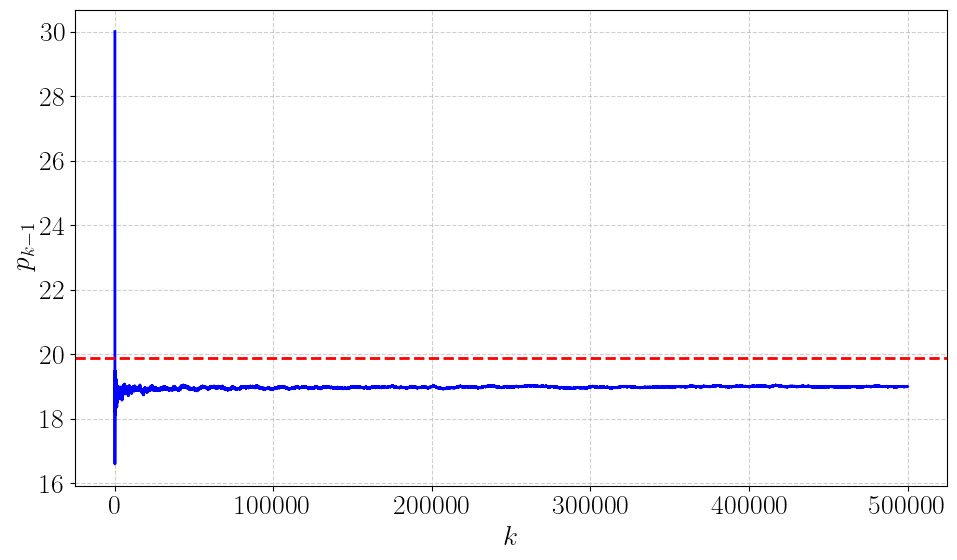

In [9]:
optimal_price = 19.9

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)

plt.figure(figsize=(10, 6))
plt.plot(price_iterates, color="blue", linewidth=2)
plt.axhline(optimal_price, color="red", linestyle="--", linewidth=2)

plt.xlabel(r"$k$", fontsize=20)
plt.ylabel(r"$p_{k-1}$", fontsize=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("price_convergence_known_parameter", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def plot_price_vs_time(price_iterates, time_iterates, optimal_price):
    """
    Plot price vs cumulative simulation time to show real-time learning progress
    """
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=20)
    
    plt.figure(figsize=(12, 6))
    
    # Plot price vs time
    plt.plot(time_iterates, price_iterates, color="blue", linestyle='none', marker='o', markersize=6)
    
    # Add horizontal line for optimal price
    plt.axhline(optimal_price, color="red", linestyle="--", linewidth=2)
    
    plt.xlabel(r"Simulation time", fontsize=20)
    plt.ylabel(r"Admission price", fontsize=20)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    plt.savefig("price_vs_time_learning_known_params.png", dpi=300, bbox_inches='tight')
    plt.show()


# Plot price vs time
plot_price_vs_time(price_iterates, time_iterates, optimal_price)

In [ ]:
def compare_window_sizes(true_model_vars, window_sizes, n_iters, initial_price, optimal_price):
    """
    Compare convergence across different window sizes
    """
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=20)
    
    plt.figure(figsize=(14, 8))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, initial_window_size in enumerate(window_sizes):
        # Run algorithm with timing tracking
        [price_iterates, time_iterates] = implement_algorithm(
            n_iters, initial_window_size, initial_price, true_model_vars)
        
        # Plot price vs time for this window size
        plt.plot(time_iterates, price_iterates, 
                color=colors[i % len(colors)], 
                linestyle='none', 
                marker='o', 
                markersize=6,
                label=f'$C = {window_sizes[i]}$')
    
    # Add horizontal line for optimal price
    plt.axhline(optimal_price, color="black", linestyle="--", linewidth=2)
    
    plt.xlabel(r"Simulation time", fontsize=20)
    plt.ylabel(r"Price $p_k$", fontsize=20)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=18, loc='upper center')
    plt.tight_layout()
    
    plt.savefig("price_convergence_window_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return None



compare_window_sizes(true_model_vars, [1, 5, 25, 125, 625, 3125], n_iters, initial_price, optimal_price)

## Auxiliary code

In [ ]:
# ## Plot for gradient waiting time

# true_model_vars = [20, 0.1, 0.2]
# price = 20
# initial_workload = 0
# window_size = 1000

# [w_minus, w_plus, interarrival_times, service_times, zetas] = queue_simulation(price, initial_workload, window_size, true_model_vars)
# w_minus = np.concatenate(([0], w_minus[0:-1]))
# w_plus = np.concatenate(([0], w_plus[0:-1]))
# gradient_waiting_time = evaluate_gradient_waiting_time(zetas, w_minus, w_plus, price, true_model_vars)

# print("Minimum gradient = ", min(gradient_waiting_time))
# print("Maximum gradient = ", max(gradient_waiting_time))

# lower_bound = -true_model_vars[1]/true_model_vars[2]

# # Create the plot
# plt.figure(figsize=(8, 2))
# plt.scatter(gradient_waiting_time, [0]*len(gradient_waiting_time), color='blue', alpha=0.7)
# # Draw interval bounds
# plt.axvline(lower_bound, color='red', linestyle='--')
# plt.axvline(0, color='green', linestyle='--')
# # Formatting
# plt.yticks([])
# plt.xlabel("Gradient of waiting time")
# # plt.title(fr"All gradient values lie in the interval [{lower_bound:.2f}, 0]")
# plt.grid(axis='x', linestyle='--', alpha=0.5)
# # plt.legend()
# plt.tight_layout()
# plt.savefig("waiting_time_gradients", dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
## Sanity checks

# Simulate queue with accept-reject method to isolate issues with F
# Hardcoded calculations with F
# 

In [ ]:
# # Sanity check 1

# # Simulate a queue with Poisson arrivals. Each arrival decides whether to join the queue or not.
# # Store effective interarrival times.
# # Obtain empirical distribution of effective interarrival times.
# # Compare with theoretical distribution of effective interarrival times.

# price = 10
# workload = 0
# n_effective = 10000000
# burn_in = 0.5 * n_effective
# effective_interarrivals = []

# for i in range(n_effective):
#     zeta = np.random.uniform(0, 1)
#     interarrival_time = inverse_F(zeta, workload, price, true_model_vars)
#     service_time = generate_service_time(1.0)
#     # service_time = generate_service_time([3.0, 2.0])
#     workload = max(0, workload - interarrival_time) + service_time
#     if i > burn_in:
#         effective_interarrivals.append(interarrival_time)

# effective_interarrivals = np.array(effective_interarrivals)
# x_vals = np.linspace(0, np.max(effective_interarrivals), 1000)
# empirical_cdf = np.array([np.mean(effective_interarrivals <= x) for x in x_vals])
# theoretical_cdf = np.array([F(x, workload, price, true_model_vars) for x in x_vals])

# plt.figure(figsize=(10, 6))
# plt.plot(x_vals, empirical_cdf, label='Empirical', linewidth=2)
# plt.plot(x_vals, theoretical_cdf, label='Theoretical', linestyle='--', linewidth=2)
# plt.xlabel('Interarrival time')
# plt.ylabel('CDF')
# plt.legend()
# plt.grid(True, alpha=0.6)
# plt.tight_layout()
# plt.show()
